# Data Path Settings

In [1]:
USE_COLAB = True

In [2]:
curren_dir = '/content/drive/MyDrive/Weeds.v3-augmented_nottrained.tensorflow'


In [3]:
shared_folder_path='/content/drive/MyDrive/Weeds.v3-augmented_nottrained.tensorflow/'


In [4]:
pasta_compartilhada="/content/drive/MyDrive/Weeds.v3-augmented_nottrained.tensorflow/"
# import os
# from google.colab import drive
# drive.mount('/content/gdrive')
# path = f"gdrive/MyDrive/{pasta_compartilhada}"
# list_files = os.listdir(shared_folder_path)


In [5]:
import os
os.getcwd()

'/content'

In [6]:
import sys
if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    #sys.path.append(curren_dir) ## Place correct
    sys.path.append(pasta_compartilhada)
else:
    sys.path.append('')

import numpy as np
import cv2
import os
from datetime import datetime

from PIL import Image

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as F

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from matplotlib import pyplot as plt
import pickle

import pandas as pd
import glob as glob
import random

Mounted at /content/drive/


In [7]:

import os
directories = [d for d in os.listdir(shared_folder_path) if os.path.isdir(os.path.join(shared_folder_path, d))]
directories

['processadas', 'originais', 'Proprias', 'ModelosTreinados']

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("We use the following device: ", device)
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1').to(device)

We use the following device:  cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 191MB/s]


In [9]:
def img_transform(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
  img /= 255.0
  img = torch.from_numpy(img).permute(2,0,1)
  return img

# Preprocessing

In [10]:
def inference(img, model, detection_threshold=0.0):
  '''
  Infernece of a single input image

  inputs:
    img: input-image as torch.tensor (shape: [C, H, W])
    model: model for infernce (torch.nn.Module)
    detection_threshold: Confidence-threshold for NMS (default=0.7)

  returns:
    boxes: bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
    labels: class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
    scores: confidence-score (Format [N] => N times confidence-score between 0 and 1)
  '''
  model.eval()

  img = img.to(device)
  outputs = model([img])

  boxes = outputs[0]['boxes'].data.cpu().numpy()
  scores = outputs[0]['scores'].data.cpu().numpy()
  labels = outputs[0]['labels'].data.cpu().numpy()

  boxes = boxes[scores >= detection_threshold].astype(np.int32)
  labels = labels[scores >= detection_threshold]
  scores = scores[scores >= detection_threshold]

  return boxes, scores, labels

In [11]:
import matplotlib.patches as patches

def plot_image(img, boxes, scores, labels, dataset, save_path=None):
  '''
  Function that draws the BBoxes, scores, and labels on the image.

  inputs:
    img: input-image as numpy.array (shape: [H, W, C])
    boxes: list of bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
    scores: list of conf-scores (Format [N] => N times confidence-score between 0 and 1)
    labels: list of class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
    dataset: list of all classes e.g. ["background", "class1", "class2", ..., "classN"] => Format [N_classes]
  '''

  cmap = plt.get_cmap("tab20b")
  class_labels = np.array(dataset)
  colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
  height, width, _ = img.shape
  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(16, 8))
  # Display the image
  ax.imshow(img,cmap='gray')
  for i, box in enumerate(boxes):
    class_pred = labels[i]
    conf = scores[i]
    width = box[2] - box[0]
    height = box[3] - box[1]
    rect = patches.Rectangle(
        (box[0], box[1]),
        width,
        height,
        linewidth=2,
        edgecolor=colors[int(class_pred)],
        facecolor="none",
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(
        box[0], box[1],
        s=class_labels[int(class_pred)] + " " + str(int(100*conf)) + "%",
        color="white",
        verticalalignment="top",
        bbox={"color": colors[int(class_pred)], "pad": 0},
    )

  # Used to save inference phase results
  if save_path is not None:
    plt.savefig(save_path)

  plt.show()

In [12]:
import os
os.listdir(sys.path[-1])
# sys.path[-1]


['sep.py',
 'one.py',
 'process.py',
 'processadas',
 'originais',
 '5to10.py',
 'Proprias',
 'ModelosTreinados',
 'Cinza5To10DatFasterRCNNWeedTemplateipynb.ipynb']

In [13]:
sys.path[-1]


'/content/drive/MyDrive/Weeds.v3-augmented_nottrained.tensorflow/'

In [14]:
os.listdir(sys.path[-1])


['sep.py',
 'one.py',
 'process.py',
 'processadas',
 'originais',
 '5to10.py',
 'Proprias',
 'ModelosTreinados',
 'Cinza5To10DatFasterRCNNWeedTemplateipynb.ipynb']

In [15]:
# sys.path[-1]+='originais/'
sys.path[-1]+='processadas/'

os.listdir(sys.path[-1])


['train-single',
 'valid',
 'test30',
 'test10',
 'train30',
 'test',
 'train',
 'train10',
 'test-single',
 'valid-single',
 'valid10',
 'valid30',
 'valid-5to10',
 'test-5to10',
 'train-5to10']

In [16]:
Dados='SingleWeed'

In [17]:
#For origininais
# df = pd.read_csv(sys.path[-1] +Dados+ '/train30/_annotations.csv')
# dfval=pd.read_csv(sys.path[-1] + Dados+'/valid30/_annotations.csv')
# dftest=pd.read_csv(sys.path[-1] + Dados+'/test30/_annotations.csv')



In [18]:
#For Process
df = pd.read_csv(sys.path[-1] + '/train-single/_annotations.csv')
dfval=pd.read_csv(sys.path[-1] + '/valid-single/_annotations.csv')
dftest=pd.read_csv(sys.path[-1] + '/test-single/_annotations.csv')



In [19]:
path_csv = sys.path[-1] + Dados+'/train30/_annotations.csv'
path_csv = sys.path[-1] +'/train-single/_annotations.csv'

img_dir = sys.path[-1] + Dados+'/train30/'
img_dir = sys.path[-1] + '/train-single/'

In [20]:
# prompt: path of dfval and imag_dir of val

# path_csv_val = sys.path[-1] +Dados+ '/valid30/_annotations.csv'
# img_dir_val = sys.path[-1] + Dados+'/valid30/'
path_csv_val = sys.path[-1] +'/valid-single/_annotations.csv'
img_dir_val = sys.path[-1] + '/valid-single/'

In [21]:
# prompt: path and img_dir para test

path_csv_test = sys.path[-1] + '/test-single/_annotations.csv'
img_dir_test = sys.path[-1] + '/test-single/'


In [22]:
# prompt: same code as the previous but for the val

import pandas as pd
dfval = pd.read_csv(path_csv_val)
print("Number of total bounding boxes: ", len(dfval))

image_paths_val = glob.glob(f"{img_dir_val}/*.jpg")
all_images_val = [image_path.split(os.path.sep)[-1] for image_path in image_paths_val]
all_images_val = sorted(all_images_val)
print("Number of unique images: ", len(all_images_val))


Number of total bounding boxes:  168
Number of unique images:  168


In [23]:
# prompt: same code as the previous but for the test

import pandas as pd
dftest = pd.read_csv(path_csv_test)
print("Number of total bounding boxes: ", len(dftest))

image_paths_test = glob.glob(f"{img_dir_test}/*.jpg")
all_images_test = [image_path.split(os.path.sep)[-1] for image_path in image_paths_test]
all_images_test = sorted(all_images_test)
print("Number of unique images: ", len(all_images_test))


Number of total bounding boxes:  83
Number of unique images:  83


In [24]:
df = pd.read_csv(path_csv)
print("Number of total bounding boxes: ", len(df))

image_paths = glob.glob(f"{img_dir}/*.jpg")
all_images = [image_path.split(os.path.sep)[-1] for image_path in image_paths]
all_images = sorted(all_images)
print("Number of unique images: ", len(all_images))

Number of total bounding boxes:  1831
Number of unique images:  1831


In [25]:
'''
Class that holds all the augmentation related attributes
'''
class Transformation():
    # This provides a random probability of the augmentation to be applied or not
    def get_probability(self):
        return np.random.choice([False, True], replace=False, p=[0.5, 0.5])

    # Increases the contrast by a factor of 2
    def random_adjust_contrast(self, image, enable=None):
        enable = self.get_probability() if enable is None else enable
        return F.adjust_contrast(image, 2) if enable else image

    # Increaes the brightness by a factor of 2
    def random_adjust_brightness(self, image, enable=None):
        enable = enable = self.get_probability() if enable is None else enable
        return F.adjust_brightness(image,2) if enable else image

    # Horizontal flip
    def random_hflip(self, image, boxes, enable=None):
        enable = enable = self.get_probability() if enable is None else enable
        if enable:
          #flip image
          new_image = F.hflip(image)

          #flip boxes
          new_boxes = boxes.clone()
          new_boxes[:, 0] = image.shape[2] - boxes[:, 0]  # image width - xmin
          new_boxes[:, 2] = image.shape[2] - boxes[:, 2]  # image_width - xmax
          new_boxes = new_boxes[:, [2, 1, 0, 3]]          # Interchange the xmin and xmax due to mirroring
          return new_image, new_boxes
        else:
          return image, boxes

In [26]:
'''
Class that holds all the augmentation related attributes
'''
class Transformation():
    # This provides a random probability of the augmentation to be applied or not
    def get_probability(self):
        return np.random.choice([False, True], replace=False, p=[0.5, 0.5])

    # Increases the contrast by a factor of 2
    def random_adjust_contrast(self, image, enable=None):
        enable = self.get_probability() if enable is None else enable
        return F.adjust_contrast(image, 2) if enable else image

    # Increaes the brightness by a factor of 2
    def random_adjust_brightness(self, image, enable=None):
        enable = enable = self.get_probability() if enable is None else enable
        return F.adjust_brightness(image,2) if enable else image

    # Horizontal flip
    def random_hflip(self, image, boxes, enable=None):
        enable = enable = self.get_probability() if enable is None else enable
        if enable:
          #flip image
          new_image = F.hflip(image)

          #flip boxes
          new_boxes = boxes.clone()
          new_boxes[:, 0] = image.shape[2] - boxes[:, 0]  # image width - xmin
          new_boxes[:, 2] = image.shape[2] - boxes[:, 2]  # image_width - xmax
          new_boxes = new_boxes[:, [2, 1, 0, 3]]          # Interchange the xmin and xmax due to mirroring
          return new_image, new_boxes
        else:
          return image, boxes
      #grayscale
    # Grayscale comentar
    def random_grayscale(self, image, enable=None):
        enable = self.get_probability() if enable is None else enable
        if enable:
            if image.shape[1] == 3:  # RGB image
                print("hola")
                image = F.rgb_to_grayscale(image)
                image = Image.fromarray(image.byte().permute(1, 2, 0).numpy())
                print("hola")
            else:
                image = image
        else:
            image = image
        return image

In [27]:
from torchvision.transforms.functional import rgb_to_grayscale

class WeedsDataset(Dataset):
  def __init__(self, img_path, label_path, classes, transforms=None):
    super().__init__()
    print("Preparing the dataset...")

    self.image_dir = img_path
    self.gt_info = pd.read_csv(label_path)
    self.classes = classes
    self.transforms = transforms

    # Create a list of image file names (in sorted order - this is optional)
    self.image_paths = glob.glob(f"{img_path}/*.jpg")
    all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
    self.all_images = sorted(all_images)

    # Map Label (str) --> Label (int)
    for i in range(len(self.gt_info)):
      label = self.gt_info.loc[i, 'class']
      self.gt_info.loc[i, 'class'] = self.classes.index(label)

    # Filter the dataset based on given conditions:
    self.filter_dataset()
    print("Dataset prepared")

  def __getitem__(self, idx):
          target = {}

          # Read input image
          image_name = self.all_images[idx]
          image_path = os.path.join(self.image_dir, image_name)
          image = cv2.imread(image_path)

          # Convert BGR to RGB
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

          # Fetch GT infos for given image
          gt_info = self.gt_info[self.gt_info['filename'] == image_name]

          boxes = torch.Tensor(gt_info[['xmin', 'ymin', 'xmax', 'ymax']].values).float()
          labels = torch.LongTensor(gt_info['class'].values.tolist())

          #if self.transforms:
              # # Apply random grayscale transformation
              # if torch.rand(1).item() > 0.5:
              #comentar se for RGB
              #image = rgb_to_grayscale(image,num_output_channels=1)

              # Apply other transformations
              # image = self.transforms(image)

          target["boxes"] = boxes     # Hint: Shape -> [N, 4] with N = Number of Boxes
          target["labels"] = labels   # Hint: Shape -> [N] with N = Number of Boxes

          return image, target

  def __len__(self):
    return len(self.all_images)

  '''
  Filter the dataset by removing images with no labels and incorrect bounding boxes
  '''
  def filter_dataset(self):
    print("Filtering the dataset...")
    remove_images = []

    # There are no labels for some images because they show an 'empty' scene → these images should be filtered out.
    for image_file in self.all_images.copy():
      if image_file not in self.gt_info['filename'].values[:]:
        remove_images.append(image_file)
        self.all_images.remove(image_file)
    print("Images removed with no labels: ", len(remove_images))

    # There are incorrect bounding boxes in the dataset (e.g. xmax=xmin).
    valid_box_mask = (self.gt_info['xmax'] - self.gt_info['xmin'] > 0) & (self.gt_info['ymax'] - self.gt_info['ymin'] > 0)
    print("Images removed with incorrect bounding boxes: ", len(self.gt_info) - valid_box_mask.shape[0])
    self.gt_info = self.gt_info[valid_box_mask] # TODO: correct this masking

In [28]:

# class WeedsDatasetGrayscale(Dataset):
#   def __init__(self, img_path, label_path, classes, transforms=None):
#     super().__init__()
#     print("Preparing the dataset...")

#     self.image_dir = img_path
#     self.gt_info = pd.read_csv(label_path)
#     self.classes = classes
#     self.transforms = transforms

#     # Create a list of image file names (in sorted order - this is optional)
#     self.image_paths = glob.glob(f"{img_path}/*.jpg")
#     all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
#     self.all_images = sorted(all_images)

#     # Map Label (str) --> Label (int)
#     for i in range(len(self.gt_info)):
#       label = self.gt_info.loc[i, 'class']
#       self.gt_info.loc[i, 'class'] = self.classes.index(label)

#     # Filter the dataset based on given conditions:
#     self.filter_dataset()
#     print("Dataset prepared")

#   def __getitem__(self, idx):
#     target = {}

#     # Read input image
#     image_name = self.all_images[idx]
#     image_path = os.path.join(self.image_dir, image_name)
#     image = cv2.imread(image_path)
#     image = self.transforms._grayscale(image, enable=True)


#     # Fetch GT infos for given image
#     gt_info = self.gt_info[self.gt_info['filename'] == image_name]

#     boxes = torch.Tensor(gt_info[['xmin', 'ymin', 'xmax', 'ymax']].values).float()
#     labels = torch.LongTensor(gt_info['class'].values.tolist())

#     if self.transforms:
#         # image = self.transforms.random_adjust_contrast(image, enable=True)
#         # image = self.transforms.to_grayscale(image, enable=True)

#         #image = self.transforms.random_adjust_brightness(image, enable=True)

#         # image, boxes = self.transforms.random_hflip(image, boxes, enable=True)

#     target["boxes"] = boxes     # Hint: Shape -> [N, 4] with N = Number of Boxes
#     target["labels"] = labels   # Hint: Shape -> [N] with N = Number of Boxes

#     return image, target

#   def __len__(self):
#     return len(self.all_images)

#   '''
#   Filter the dataset by removing images with no labels and incorrect bounding boxes
#   '''
#   def filter_dataset(self):
#     print("Filtering the dataset...")
#     remove_images = []

#     # There are no labels for some images because they show an 'empty' scene → these images should be filtered out.
#     for image_file in self.all_images.copy():
#       if image_file not in self.gt_info['filename'].values[:3000]:
#         remove_images.append(image_file)
#         self.all_images.remove(image_file)
#     print("Images removed with no labels: ", len(remove_images))

#     # There are incorrect bounding boxes in the dataset (e.g. xmax=xmin).
#     valid_box_mask = (self.gt_info['xmax'] - self.gt_info['xmin'] > 0) & (self.gt_info['ymax'] - self.gt_info['ymin'] > 0)
#     print("Images removed with incorrect bounding boxes: ", len(self.gt_info) - valid_box_mask.shape[0])
#     self.gt_info = self.gt_info[valid_box_mask] # TODO: correct this masking

In [ ]:
import torchvision.transforms as T

crowdai = ["Background", "Weeds"]
transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.ColorJitter(brightness=0.5, contrast=0.5)
])

# dataset = WeedsDatasetGrayscale(img_dir, path_csv, crowdai, transforms=TransformationGrayScale) # here your arguments
dataset=WeedsDataset(img_dir, path_csv, crowdai, transforms=transforms)
num_images = 5

for _ in range(num_images):
  x = random.randint(0, (dataset.__len__()-1))
  img, target = dataset.__getitem__(x)
  print(type(img))
  print(img.shape)
  img = img.cpu().permute(1,2,0).numpy()
  boxes = target['boxes'].numpy()
  labels = target['labels'].numpy()
  scores = [1]*len(labels)
  print("Image index: ", x)
  plot_image(img, boxes, scores, labels, crowdai)

# Hyperparameters

In [163]:
# Hyperparameters

SEED = 42

TEST_SIZE = 0.2

NUM_EPOCHS = 10

LR = 0.005
LR_MOMENTUM=0.9
LR_DECAY_RATE=0.0005

LR_SCHED_STEP_SIZE = 0.1
LR_SCHED_GAMMA = 0.1

BATCH_SIZE = 16

NUM_TEST_IMAGES = 5
NMS_THRESH = 0.01

In [164]:
current_dir = curren_dir if USE_COLAB else os.getcwd()

# Fetch current date and time
now = datetime.now()
dt_string = now.strftime(Dados+"CinzaOriginais_"+"%d-%m-%Y-%H-%M-%S")
output_dir_name = "output-" + dt_string

OUTPUT_DIR = os.path.join(current_dir, output_dir_name)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [165]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(min_size=300, max_size=480, pretrained=False)
num_classes = 2  # 3 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

num_epochs = NUM_EPOCHS

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LR, momentum=LR_MOMENTUM, weight_decay=LR_DECAY_RATE)

# create a train- and validation-dataset with our vehicleDataset
# split the dataset in train and test set
#dataset = WeedsDataset(img_dir, path_csv, crowdai, transforms=Transformation())      # here your arguments
dataset=WeedsDataset(img_dir, path_csv, crowdai, transforms=transforms)

dataset_valid = WeedsDataset(img_dir_val, path_csv_val, crowdai, transforms=None)             # here your arguments

torch.manual_seed(SEED)
indices = torch.randperm(len(dataset)).tolist()

test_size = int(len(dataset) * TEST_SIZE)
#dataset = torch.utils.data.Subset(dataset, indices[:-test_size])
dataset = torch.utils.data.Subset(dataset, indices[:])

#dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_size:])
dataset_test = torch.utils.data.Subset(dataset_valid, indices[:])

# create a learning rate scheduler
# TODO: step size to be tuned !
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, \
                                                step_size=LR_SCHED_STEP_SIZE, \
                                                gamma=LR_SCHED_GAMMA)

def collate_fn(batch):
  return tuple(zip(*batch))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,
  collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
  dataset_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=2,
  collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Preparing the dataset...
Filtering the dataset...
Images removed with no labels:  0
Images removed with incorrect bounding boxes:  0
Dataset prepared
Preparing the dataset...
Filtering the dataset...
Images removed with no labels:  0
Images removed with incorrect bounding boxes:  0
Dataset prepared


In [166]:
num_channels = dataset[0][0].shape[0]

print(f"Número de canales por imagen: {num_channels}")

Número de canales por imagen: 3


# GrayScale adaptation for the model

In [167]:
# import torchvision
# import torchvision.models.detection as detection
# import torchvision.models.detection.faster_rcnn as faster_rcnn
# import torch.nn as nn
# # Load the pre-trained Faster R-CNN model
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(min_size=300, max_size=480, pretrained=True)
# #     backbone='resnet50',
# #     num_classes=2,
# #     rpn_anchor_generator=detection.rpn.anchor_generator.AnchorGenerator(
# #         sizes=((32, 64, 128, 256, 512),),
# #         aspect_ratios=((0.5, 1.0, 2.0),)
# #     ),
# #     box_roi_pool=detection.rpn.box_roi_pool.MultiScaleRoIAlign(
# #         featmap_names=['0'],
# #         output_size=7,
# #         sampling_ratio=2
# #     )
# # )

# # Modify the input layer to accept grayscale images
# model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)



# Train the model

In [168]:
# import torchvision
# import torchvision.models.detection as detection

# # Load the pre-trained Faster R-CNN model
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
#     min_size=300,
#     max_size=480,
#     pretrained=True
# )

# # Modify the input layer to accept grayscale images
# model.backbone.body.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).requires_grad_(True)

# # Modify the normalization layer
# # model.transform = torchvision.transforms.Compose([
# #     torchvision.transforms.ToTensor(),
# #     torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
# # ])

# # Train the model

In [169]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(300,), max_size=480, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu)

In [170]:
'''
Function to train the model over one epoch.
'''
def train_one_epoch(model, optimizer, data_loader, device, epoch):
  train_loss_list = []

  tqdm_bar = tqdm(data_loader, total=len(data_loader))
  for idx, data in enumerate(tqdm_bar):
    optimizer.zero_grad()
    images, targets = data

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # targets = {'boxes'=tensor, 'labels'=tensor}

    losses = model(images, targets)

    loss = sum(loss for loss in losses.values())
    loss_val = loss.item()
    train_loss_list.append(loss.detach().cpu().numpy())

    loss.backward()
    optimizer.step()

    tqdm_bar.set_description(desc=f"Training Loss: {loss:.3f}")

  return train_loss_list

'''
Function to validate the model
'''
def evaluate(model, data_loader_test, device):
    val_loss_list = []

    tqdm_bar = tqdm(data_loader_test, total=len(data_loader_test))

    for i, data in enumerate(tqdm_bar):
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            losses = model(images, targets)

        loss = sum(loss for loss in losses.values())
        loss_val = loss.item()
        val_loss_list.append(loss_val)

        tqdm_bar.set_description(desc=f"Validation Loss: {loss:.4f}")
    return val_loss_list

'''
Function to plot training and valdiation losses and save them in `output_dir'
'''
def plot_loss(train_loss, valid_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    train_ax.plot(train_loss, color='blue')
    train_ax.set_xlabel('Iteration')
    train_ax.set_ylabel('Training Loss')

    valid_ax.plot(valid_loss, color='red')
    valid_ax.set_xlabel('Iteration')
    valid_ax.set_ylabel('Validation loss')

    figure_1.savefig(f"{OUTPUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUTPUT_DIR}/valid_loss.png")

In [171]:
print("HOLA")

HOLA


In [172]:
print(len(data_loader))

69


# Training

----------Epoch 1----------


Validation Loss: 0.4934: 100%|██████████| 7/7 [00:45<00:00,  6.48s/it]


----------Epoch 2----------


Validation Loss: 0.6181: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


----------Epoch 3----------


Validation Loss: 0.4253: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


----------Epoch 4----------


Validation Loss: 0.3500: 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


----------Epoch 5----------


Validation Loss: 0.3593: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


----------Epoch 6----------


Validation Loss: 0.3290: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


----------Epoch 7----------


Validation Loss: 0.3459: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


----------Epoch 8----------


Validation Loss: 0.3077: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


----------Epoch 9----------


Validation Loss: 0.2842: 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


----------Epoch 10----------


Validation Loss: 0.3392: 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


Training Finished !


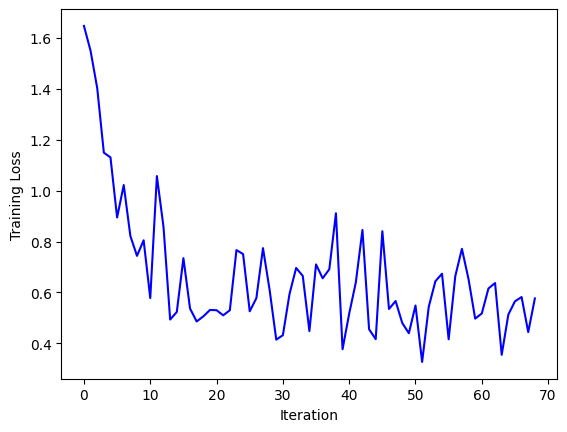

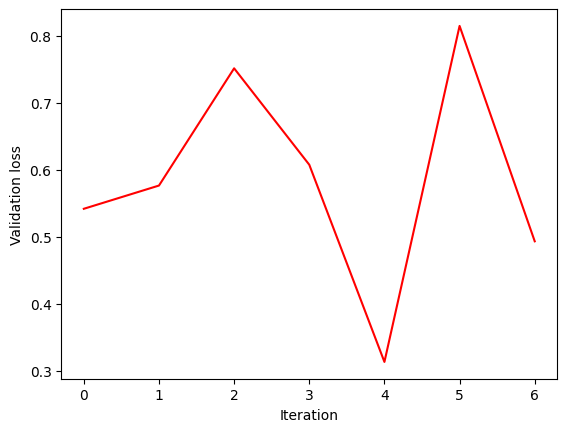

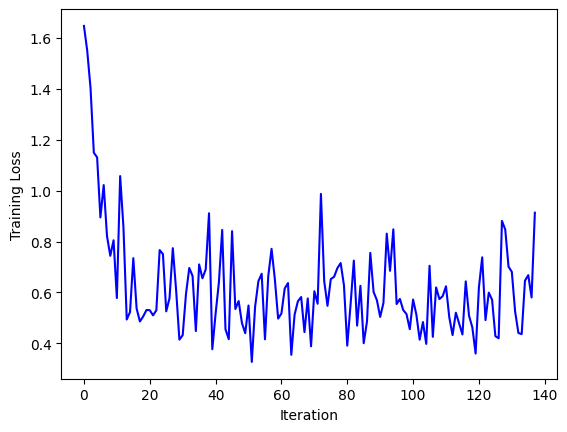

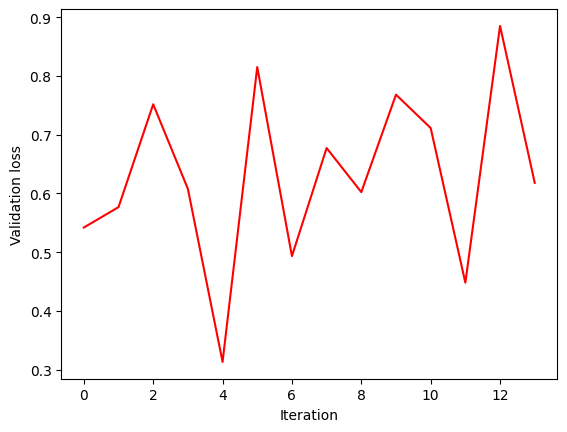

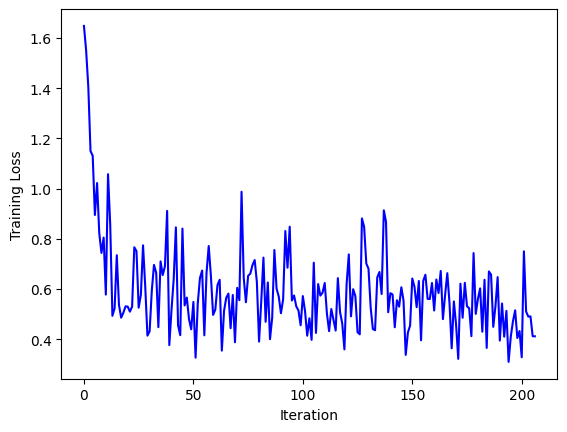

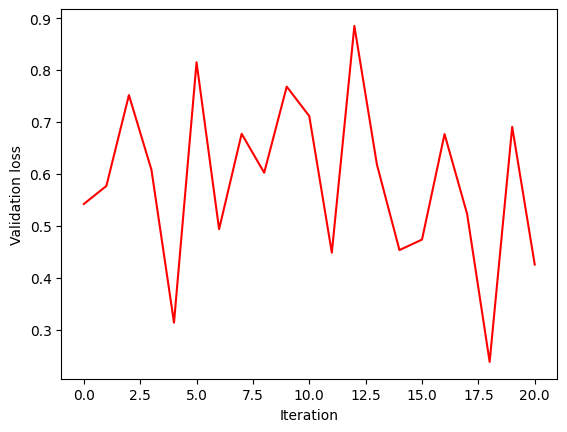

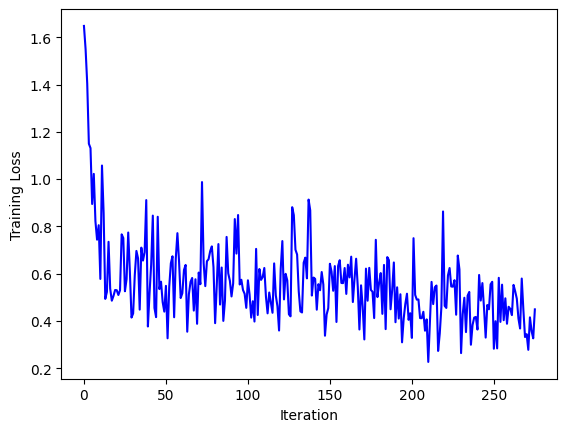

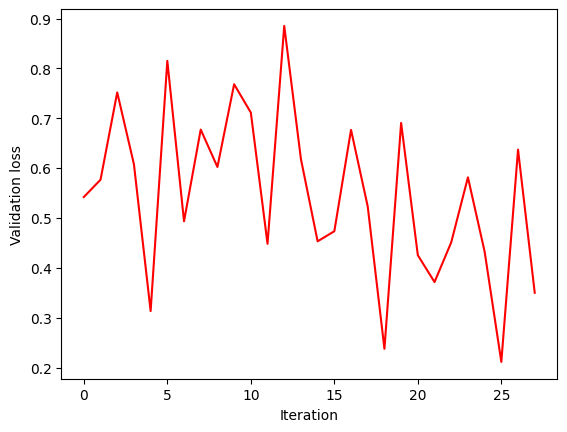

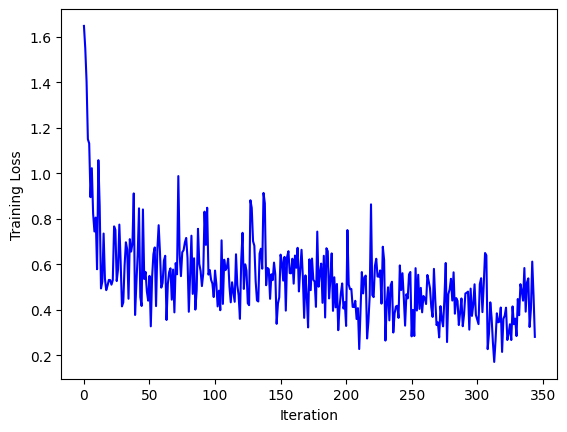

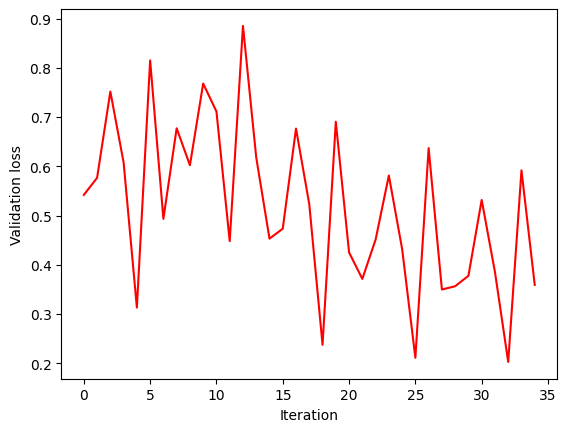

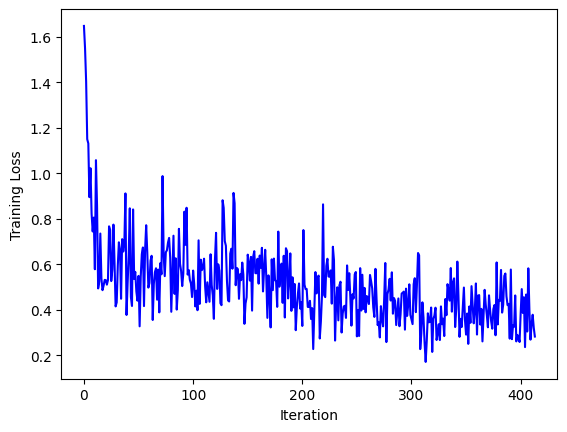

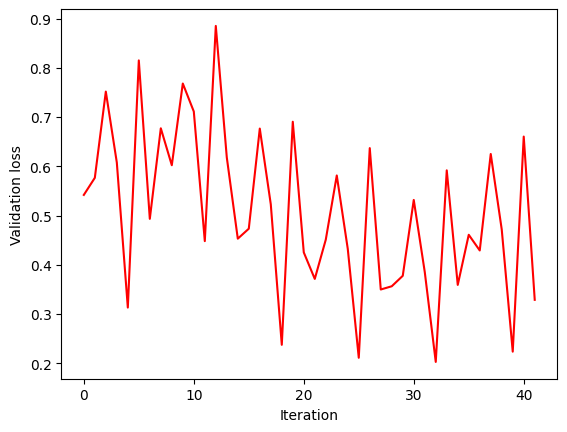

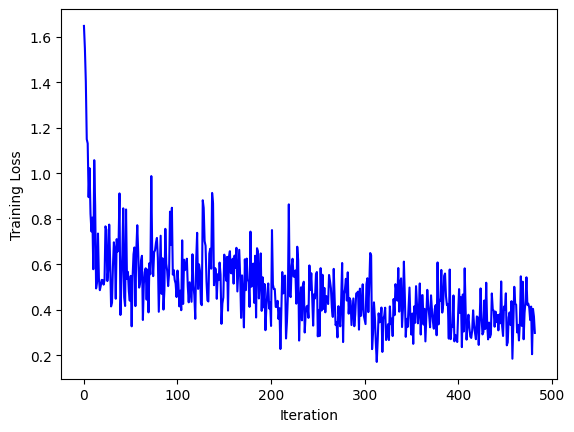

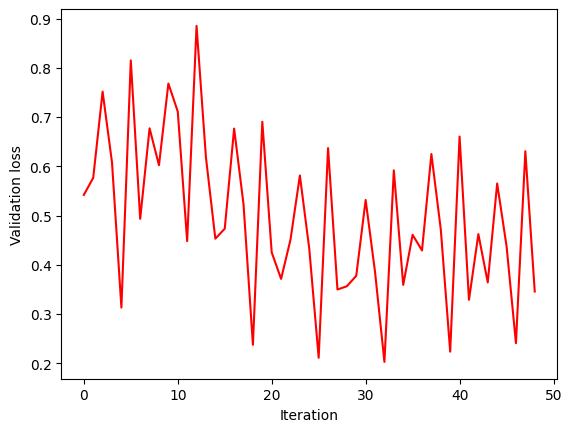

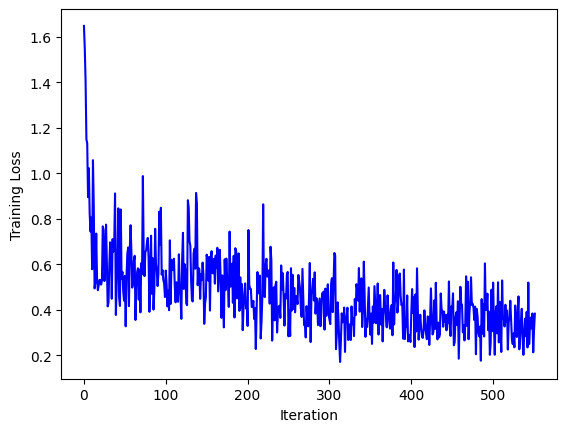

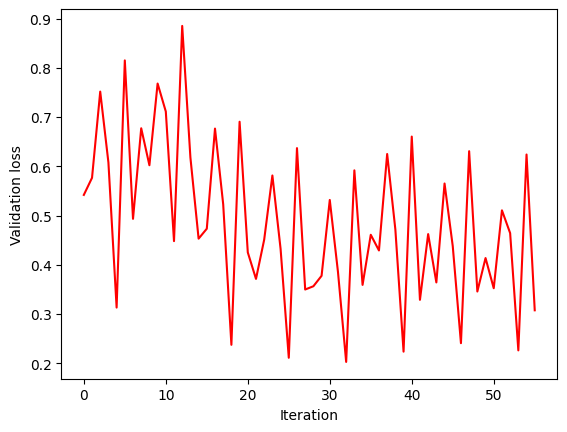

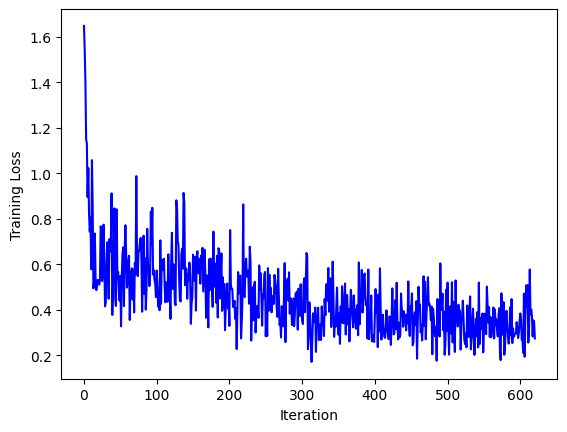

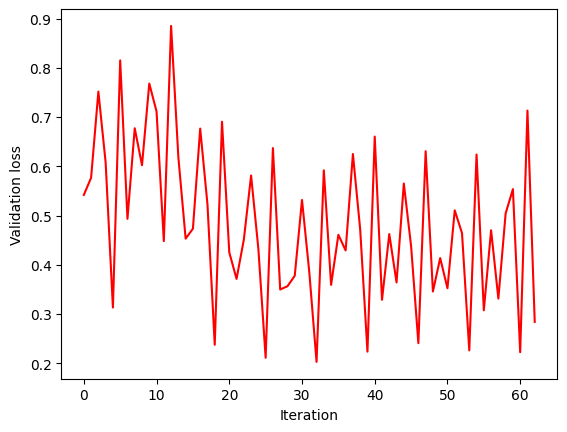

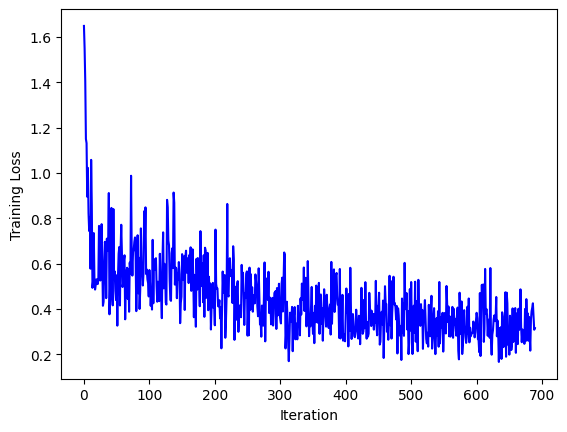

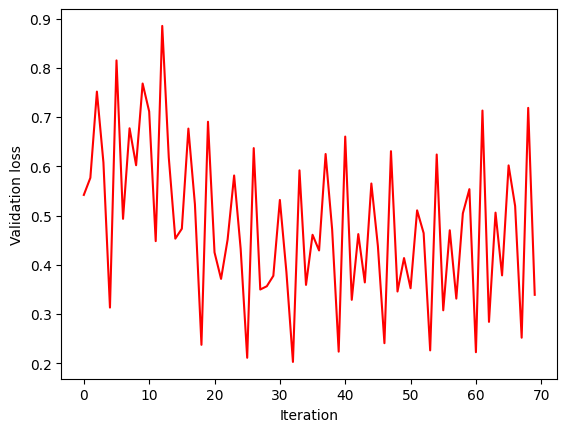

In [173]:
# find latest saved chcekpoint
checkpoint_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.pth')]
if checkpoint_files:
    # Last ckpt file
    checkpoint_files.sort()
    latest_checkpoint = os.path.join(OUTPUT_DIR, checkpoint_files[-1])

    # Load the ckpt
    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss_dict = checkpoint['loss_dict']
else:
    start_epoch = 0
    loss_dict = {'train_loss': [], 'valid_loss': []}

'''
Train the model over all epochs
'''
for epoch in range(start_epoch, num_epochs):
  print("----------Epoch {}----------".format(epoch+1))

  # Train the model for one epoch
  train_loss_list = train_one_epoch(model, optimizer, data_loader, device, epoch)
  loss_dict['train_loss'].extend(train_loss_list)

  lr_scheduler.step()

  # Run evaluation
  valid_loss_list = evaluate(model, data_loader_test, device)
  loss_dict['valid_loss'].extend(valid_loss_list)

  # Svae the model ckpt after every epoch
  ckpt_file_name = f"{OUTPUT_DIR}/epoch_{epoch+1}_model.pth"
  torch.save({
    'epoch': epoch+1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_dict': loss_dict
  }, ckpt_file_name)

  # NOTE: The losses are accumulated over all iterations
  plot_loss(loss_dict['train_loss'], loss_dict['valid_loss'])

# Store the losses after the training in a pickle
with open(f"{OUTPUT_DIR}/loss_dict.pkl", "wb") as file:
    pickle.dump(loss_dict, file)

print("Training Finished !")

#Testing


## Simple Test

[[ 13   8 336 339]
 [  1 279  90 358]
 [352 289 409 379]
 [170 190 285 304]] [0.9989617  0.99824995 0.5098557  0.18076828] [1 1 1 1]


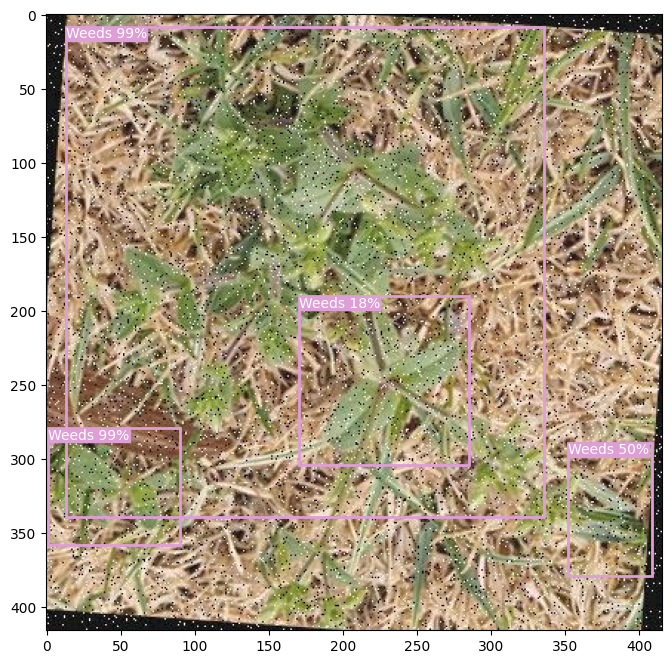

[[127  89 327 311]] [0.99970144] [1]


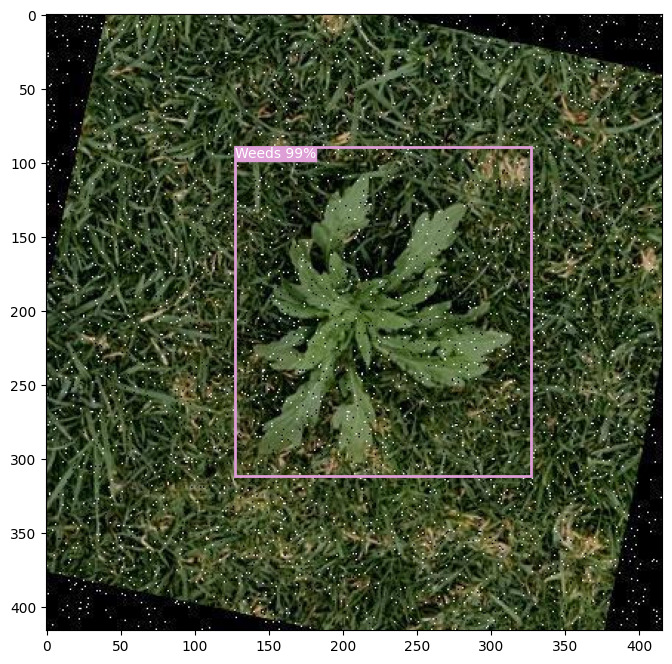

[[248 278 298 310]
 [144 185 219 238]
 [229 199 276 241]
 [151 182 276 251]
 [250 289 282 311]
 [247 271 288 299]] [0.96579427 0.9541141  0.8265386  0.5780143  0.06236728 0.05061309] [1 1 1 1 1 1]


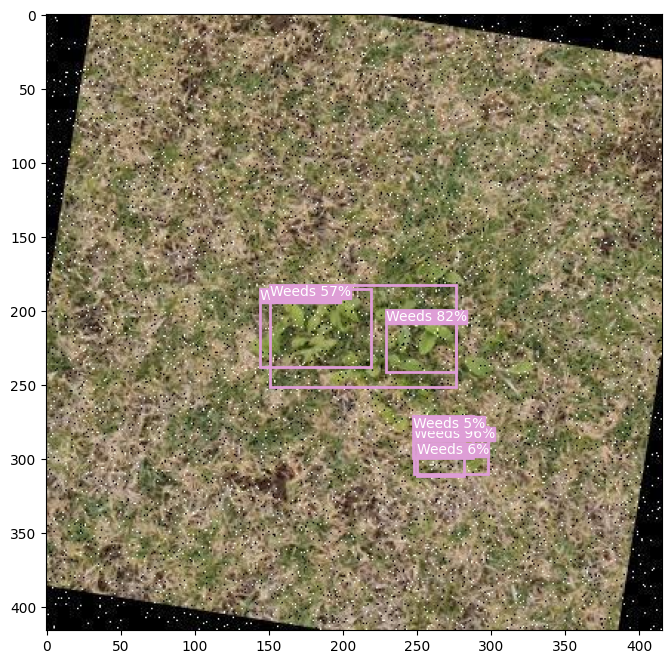

[[296 169 416 339]
 [ 87  10 253 132]
 [ 98 150 314 393]
 [192 139 311 250]
 [261  41 331 114]
 [128 272 308 416]
 [313  85 332 111]
 [385 179 416 211]
 [377 317 414 361]
 [395 272 415 312]
 [249   9 357 113]
 [161 316 285 410]
 [405 272 414 319]
 [379 285 416 366]
 [402 178 416 218]
 [294 154 323 185]
 [161 142 383 378]
 [203  33 236  64]
 [360 178 416 223]
 [  6 249  27 308]
 [183  63 251 115]] [0.99931777 0.9991104  0.9975822  0.97529924 0.8935211  0.7613322
 0.41311204 0.36266965 0.23748754 0.20476435 0.16962749 0.15804343
 0.10704248 0.10645263 0.09396483 0.07426299 0.07283708 0.07254606
 0.06949734 0.06009968 0.05084373] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


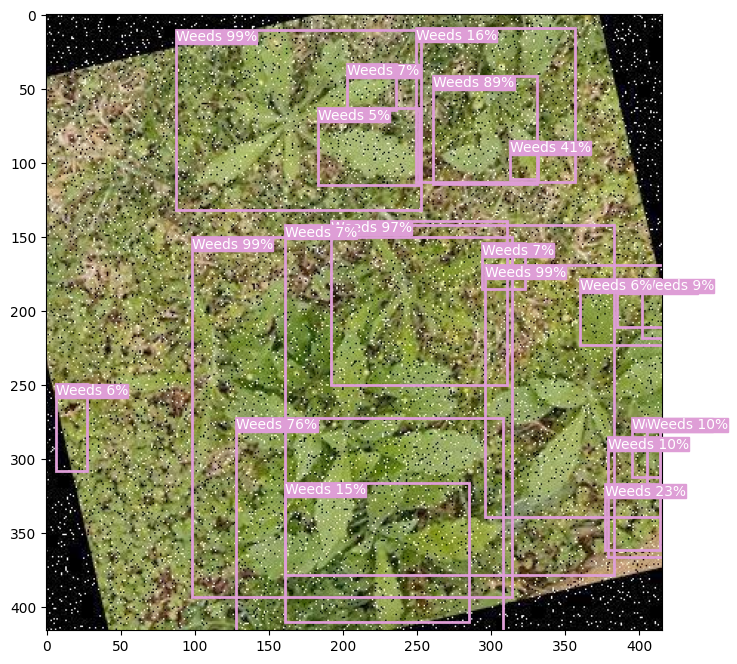

[[314 257 414 381]] [0.99836797] [1]


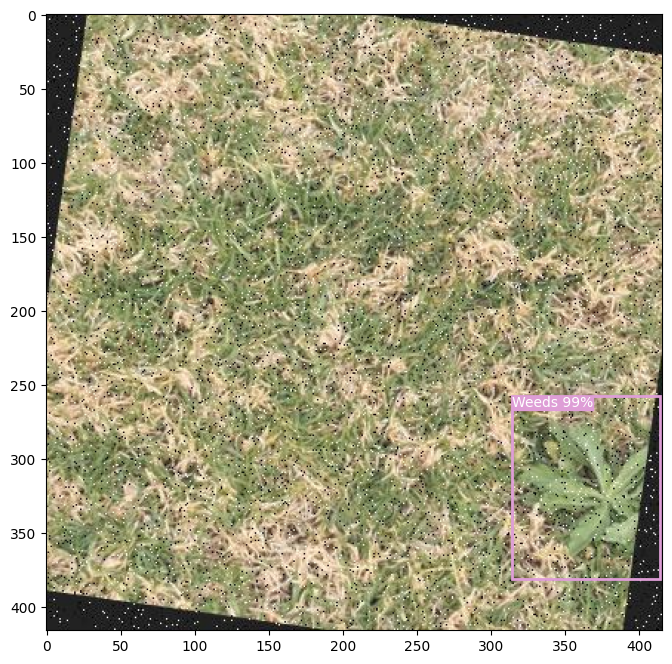

In [ ]:
random.seed(SEED)
crowdai = ["Background",'Weeds']
num_images = NUM_TEST_IMAGES

for _ in range(num_images):
  x = random.randint(0, (dataset_test.__len__()-1))
  img, target = dataset_test.__getitem__(x)
  img = img.to(device)

  # Load last checkpoint
  # CHANGE THE OUTPUT_DIR IF CKPT IS STORED ELSEWHERE
  output_dir_name='output-05-06-2024-01-14-58'
  OUTPUT_DIR = os.path.join(current_dir, output_dir_name)

  checkpoint_dir = f"/{OUTPUT_DIR}/epoch_15_model.pth"
  checkpoint = torch.load(checkpoint_dir, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])

  boxes, scores, labels = inference(img, model)
  print(boxes,scores,labels)
  img = img.squeeze(0).cpu().permute(1,2,0).numpy()
  plot_image(img, boxes, scores, labels, crowdai, save_path=f"{OUTPUT_DIR}/inference_{x}.png")

In [ ]:
random.seed(SEED)
crowdai = ["Background",'Weeds']
num_images = NUM_TEST_IMAGES

for _ in range(num_images):
  x = random.randint(0, (dataset_test.__len__()-1))
  img, target = dataset_test.__getitem__(x)
  img = img.to(device)

  # Load last checkpoint
  # CHANGE THE OUTPUT_DIR IF CKPT IS STORED ELSEWHERE
  checkpoint_dir = f"/{OUTPUT_DIR}/epoch_10_model.pth"
  checkpoint = torch.load(checkpoint_dir, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])

  boxes, scores, labels = inference(img, model)
  print(boxes,scores,labels)
  img = img.squeeze(0).cpu().permute(1,2,0).numpy()
  plot_image(img, boxes, scores, labels, crowdai, save_path=f"{OUTPUT_DIR}/inference_{x}.png")

In [ ]:
import random
random.seed(SEED)
crowdai = ["Background",'Weeds']
num_images = 3 #NUM_TEST_IMAGES
TP=[]
FP=[]
FN=[]
Confidence=[]
Tresh=0.75
for _ in range(num_images):
  x = random.randint(0, (dataset_test.__len__()-1))
  img, target = dataset_test.__getitem__(x)
  teorBoundB=target['boxes'].tolist()
  print(teorBoundB)
  TeornumofBoxes=len(teorBoundB)
  print(TeornumofBoxes)
  img = img.to(device)

  # Load last checkpoint
  # CHANGE THE OUTPUT_DIR IF CKPT IS STORED ELSEWHERE
  output_dir_name='output-31-05-2024-16-08-27'
  OUTPUT_DIR=os.path.join(current_dir, output_dir_name)
  checkpoint_dir = f"/{OUTPUT_DIR}/epoch_3_model.pth"
  checkpoint = torch.load(checkpoint_dir, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])

  boxes, scores, labels = inference(img, model)

  print(boxes)
  detecnumboxes=len(boxes)
  print(detecnumboxes)
  print('Scores(IoU): ',scores)
  Confidence.append(scores)
  print("> Tresh",boxes[scores>Tresh])
  for box in boxes[scores>Tresh]:
    TP.append(1)
    FP.append(0)
    FN.append(TeornumofBoxes)

  for box in boxes[scores<Tresh]:
    FP.append(1)
    TP.append(0)
    FN.append(TeornumofBoxes)






  img = img.squeeze(0).cpu().permute(1,2,0).numpy()
  plot_image(img, boxes, scores, labels, crowdai, save_path=f"{OUTPUT_DIR}/inference_{x}.png")

## Model 1

2
2
1
1
2
2
4
1
1
1
1
1
1
1
2
7
3
1
1
1
TP: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
FP: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
FN: [35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 9, 8, 7, 7, 7, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Recall: [0.027777777777777776, 0.05555555555555555, 0.08333333333333333, 0.1111111111111111, 0.1388888888888889, 0.16666666666666666, 0.19444444444444445, 0.2222222222222222, 0.25, 0.2777777777777778, 0.30555555555555

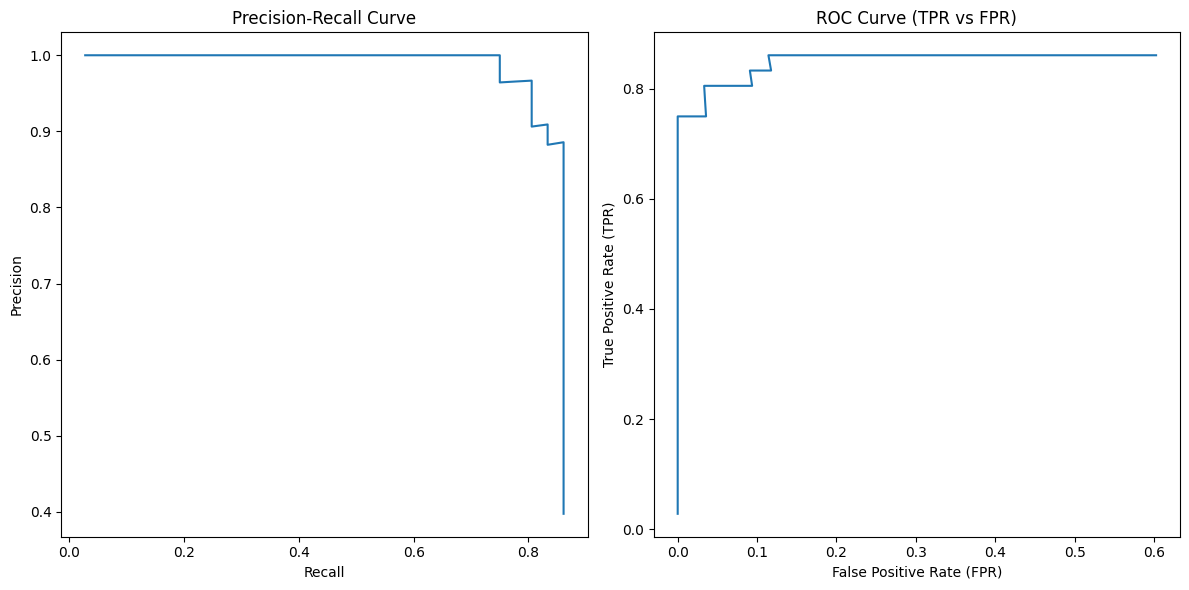

In [ ]:
import random
import os
import torch
import matplotlib.pyplot as plt

random.seed(SEED)

crowdai = ["Background", 'Weeds']
num_images = 20  # NUM_TEST_IMAGES
Tresh = 0.75
IoU_threshold = 0.5  # Threshold for IoU to consider a detection as TP

TP = []
FP = []
FN = []
Confidence = []

recall_list = []
precision_list = []
tpr_list = []
fpr_list = []

# Lista global para todas las detecciones
global_detections = []

# Calcular el total de objetos reales en todas las imágenes
total_real_objects = 0

# Función para calcular IoU
def calculate_iou(box1, box2):
    # Calcular coordenadas de la intersección
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Área de intersección
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Áreas de los cuadros individuales
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Área de la unión
    union_area = box1_area + box2_area - inter_area

    # Calcular IoU
    iou = inter_area / union_area
    return iou

# Procesar cada imagen
for _ in range(num_images):
    x = random.randint(0, (dataset_test.__len__() - 1))
    img, target = dataset_test.__getitem__(x)
    # print(len(target))
    teorBoundB = target['boxes'].tolist()

    TeornumofBoxes = len(teorBoundB)
    print(TeornumofBoxes)
    total_real_objects += TeornumofBoxes
    img = img.to(device)

    # Cargar el último checkpoint
    # output_dir_name = 'output-31-05-2024-16-08-27'
    OUTPUT_DIR = os.path.join(current_dir, output_dir_name)
    checkpoint_dir = f"/{OUTPUT_DIR}/epoch_15_model.pth"
    checkpoint = torch.load(checkpoint_dir, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    boxes, scores, labels = inference(img, model)

    # Agregar detecciones a la lista global
    global_detections.extend(zip(boxes, scores, [teorBoundB] * len(boxes)))

# Ordenar todas las detecciones por puntaje
global_detections = sorted(global_detections, key=lambda x: x[1], reverse=True)

# Inicializar acumuladores
acumulate_TP = 0
acumulate_FP = 0
acumulate_FN = total_real_objects

# Procesar cada detección globalmente
for box, score, ground_truth_boxes in global_detections:
    if score > Tresh:
        # Calcular IoU con todos los cuadros verdaderos
        iou_values = [calculate_iou(box, gt_box) for gt_box in ground_truth_boxes]
        max_iou = max(iou_values) if iou_values else 0

        if max_iou >= IoU_threshold:
            TP.append(1)
            FP.append(0)
            acumulate_TP += 1
            acumulate_FN -= 1
        else:
            TP.append(0)
            FP.append(1)
            acumulate_FP += 1
    else:
        TP.append(0)
        FP.append(1)
        acumulate_FP += 1

    FN.append(total_real_objects - acumulate_TP)
    Confidence.append(score)

    # Calcular recall, precisión, TPR y FPR para cada detección
    recall = acumulate_TP / total_real_objects
    precision = acumulate_TP / (acumulate_TP + acumulate_FP) if (acumulate_TP + acumulate_FP) > 0 else 0
    tpr = acumulate_TP / total_real_objects
    fpr = acumulate_FP / (acumulate_FP + acumulate_TP)

    recall_list.append(recall)
    precision_list.append(precision)
    tpr_list.append(tpr)
    fpr_list.append(fpr)

print("TP:", TP)
print("FP:", FP)
print("FN:", FN)
print("Recall:", recall_list)
print("Precision:", precision_list)
print("TPR:", tpr_list)
print("FPR:", fpr_list)

# Calcular el Average Precision (AP)
def calculate_ap(recall_list, precision_list):
    # Asegúrate de que las listas estén ordenadas por recall
    recall_precision_pairs = sorted(zip(recall_list, precision_list))
    recall_list_sorted, precision_list_sorted = zip(*recall_precision_pairs)

    # Interpolación para el cálculo de AP
    recall_levels = [i / 10 for i in range(11)]  # Niveles de recall de 0.0 a 1.0
    precision_interpolated = []

    for recall_level in recall_levels:
        precisions_at_recall_level = [p for r, p in zip(recall_list_sorted, precision_list_sorted) if r >= recall_level]
        if precisions_at_recall_level:
            precision_interpolated.append(max(precisions_at_recall_level))
        else:
            precision_interpolated.append(0)

    # Calcular el AP como el promedio de precisiones interpoladas
    ap = sum(precision_interpolated) / len(recall_levels)
    return ap

ap = calculate_ap(recall_list, precision_list)
print("Average Precision (AP):", ap)

# Graficar precision vs recall y TPR vs FPR
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Curva Precision-Recall
axs[0].plot(recall_list, precision_list)
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision-Recall Curve')

# Curva TPR-FPR
axs[1].plot(fpr_list, tpr_list )
axs[1].set_xlabel('False Positive Rate (FPR)')
axs[1].set_ylabel('True Positive Rate (TPR)')
axs[1].set_title('ROC Curve (TPR vs FPR)')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import auc

fpr_list_sorted = sorted(fpr_list)
tpr_list_sorted = [tpr_list[fpr_list.index(fpr)] for fpr in fpr_list_sorted]

# Calcular el Área Bajo la Curva (AUC) para la curva ROC
roc_auc = auc(recall_list, precision_list)
print("Area Under Curve (AUC) for ROC:", roc_auc)

Area Under Curve (AUC) for ROC: 0.6892248523844409


In [ ]:
from sklearn.metrics import auc

fpr_list_sorted = sorted(fpr_list)
tpr_list_sorted = [tpr_list[fpr_list.index(fpr)] for fpr in fpr_list_sorted]

# Calcular el Área Bajo la Curva (AUC) para la curva ROC
roc_auc = auc(recall_list, precision_list)
print("Area Under Curve (AUC) for ROC:", roc_auc)

Area Under Curve (AUC) for ROC: 0.5625


In [ ]:
print(len(dataset_test))